Globally averaged temperature:

$$
\frac{dT}{dt} = R_i(T) -  R_0(T, C)
$$

Accumulated anthropogenic carbon, $S_a$
$$
\frac{d S_a}{dt} = C_a
$$

Atmospheric carbon concentration:

$$
\frac{dC}{dt} = v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))
$$

Temperature anomaly:
$$
\tilde{T} = T - T_{preindustrial}
$$



$$
\begin{align}
\delta \phi(\tilde{T}, C, S_a) =& \max_{C_a} \eta \log C_a  \\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} \left( R_i(T) - R_0(T, C) \right)\\
& + \frac{d\phi(\tilde{T}, C, S_a)}{d C} \left( v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))\right)\\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} C_a \\
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 \tilde{T}) (R_i(T) - R_0(T, C))
\end{align}
$$

$$
C_a^{*} = - \frac{ \eta}{\frac{d \phi (\tilde{T}, C, S_a)}{d C} + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} }
$$

In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import SymLogNorm
import matplotlib.mlab
import scipy.io as sio
import pandas as pd
import scipy.optimize as optim
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import fft, arange, signal
from scipy.interpolate import RegularGridInterpolator
import SolveLinSys
from supportfunctions import finiteDiff
rcParams["figure.figsize"] = (8,5)
                                                                                
def PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, 
              ε = 1, tol = -10):                                              
                                                                                 

    A = A.reshape(-1,1,order = 'F')                                         
    B = np.hstack([B1.reshape(-1,1,order = 'F'),B2.reshape(-1,1,order = 'F'),B3.reshape(-1,1,order='F')])
    C = np.hstack([C1.reshape(-1,1,order = 'F'),C2.reshape(-1,1,order = 'F'),C3.reshape(-1,1,order='F')])
    D = D.reshape(-1,1,order = 'F')                                         
    v0 = v0.reshape(-1,1,order = 'F')                                       
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)           

    return out                                                            

In [34]:
# Pre-industrial: 282.87K

sa = 1
Ts = 282.9
Cs = 275.5

Q0 = 342.5
p = 0.3
# outgoing radiation linearized
kappa = 1.74
Tkappa = 154
## CO2 radiative forcing
# Greenhouse effect parameter
B = 5.35

alphaland = 0.28
bP = 0.05
bB = 0.08
cod = 3.035
cearth = 0.107
tauc = 20
coc0 =350
## Ocean albedo parameters
Talphaocean_low = 219
Talphaocean_high = 299
alphaocean_max = 0.84
alphaocean_min = 0.255

Cbio_low = 50
Cbio_high = 700

T0 = 298
C0 = 280

## CO2 uptake by vegetation
wa = 0.015
vegcover = 0.4

Thigh = 315
Tlow = 282
Topt1 = 295
Topt2 = 310
acc = 5

## Volcanism
Volcan = 0.028


def alphaocean(T):
    """T, matrix, (nT, nC, nF)"""
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = alphaocean_max
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = alphaocean_min

    return temp
    
#Fraction of ocean covered by ice
def fracseaice(T):
    
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = 1
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = 0

    return temp
    


def biopump(F):
    """F, accumulated anthrpogenic emission"""
    temp = np.zeros(F.shape)
    
    temp[F < Cbio_low] = 1
    temp[(F >= Cbio_low)&(F < Cbio_high)] = 1 - 1/(Cbio_high - Cbio_low) * (F[(F >= Cbio_low)&(F < Cbio_high)] - Cbio_low)
    temp[F >= Cbio_high] = 0
    return temp


def veggrowth(T):
    
    temp = np.zeros(T.shape)
    
    temp[T < Tlow] = 0
    temp[(T >= Tlow)&(T < Topt1)] = acc / (Topt1 - Tlow) * (T[(T >= Tlow)&(T < Topt1)] - Tlow)
    temp[(T >= Topt1)&(T < Topt2)] = acc
    temp[(T >= Topt2)&(T < Thigh)] = acc / (Topt2 - Thigh) * (T[(T >= Topt2)&(T < Thigh)] - Thigh)
    temp[T > Thigh] = 0
    
    return temp


#Incoming radiation modified by albedo
def Ri(T):
    return 1/cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(T)))

# Outgoing radiation modified by greenhouse effect
def Ro(T, C):
    return 1/cearth * (kappa * (T - Tkappa) -  B * np.log(C / C0))

#Solubility of atmospheric carbon into the oceans
# carbon pumps
def kappaP(T):
    return np.exp(-bP * (T - T0))

def oceanatmphysflux(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def oceanbioflux(T, F, sa):
    
    if sa == 1:
        
        return 1/tauc * (coc0 * (np.exp(bB * biopump(F) * (T - T0))))
    
    elif sa == 0:
        
        return 1/tauc * (coc0 * (np.exp(bB * (T - T0))))
    
    else:
        return ValueError("Wrong input value: 0 or 1.")

def oceanatmcorrflux(C):
    return 1 / tauc * (- cod * C)

In [11]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 0. 
T_max  = 20. # 
hT     = 0.2
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 250
C_max  = 500
hC     = 10
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 280. # 10. avaoid 
F_max = 2500. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 50.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(101, 26, 46)

In [12]:
To = 282.87 # Mean with no anthropogenic carbon emissions, in Fᵒ

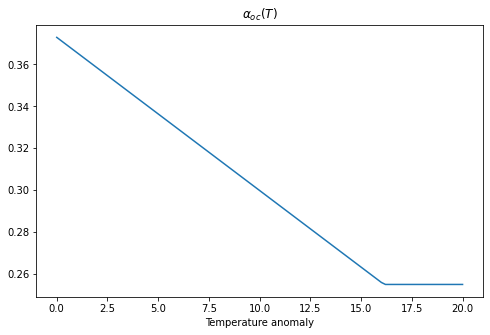

(0.255, 0.372950625)

In [13]:
α_ocean = alphaocean(T_grid + To)
plt.plot(T_grid, α_ocean)
plt.xlabel("Temperature anomaly")
plt.title("$α_{oc}(T)$")
plt.show()
α_ocean.min(), α_ocean.max()

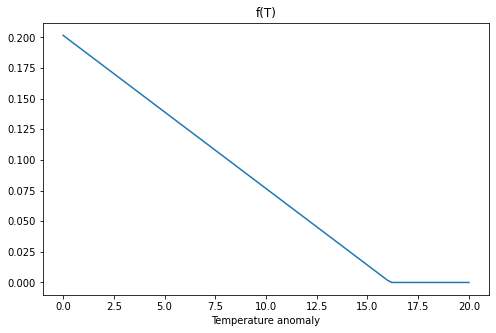

(0.0, 0.20162499999999994)

In [14]:
frac_sea_ice = fracseaice(T_grid + To)
plt.plot(T_grid, frac_sea_ice)
plt.xlabel("Temperature anomaly")
plt.title("f(T)")
plt.show()
frac_sea_ice.min(), frac_sea_ice.max()

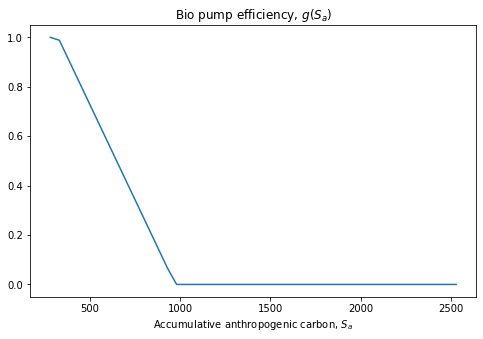

In [16]:
Fo = 272.3
bio_pump_efficiency = biopump(F_grid - Fo)
plt.plot(F_grid, bio_pump_efficiency)
plt.xlabel("Accumulative anthropogenic carbon, $S_a$")
plt.title("Bio pump efficiency, $g(S_a)$")
plt.show()

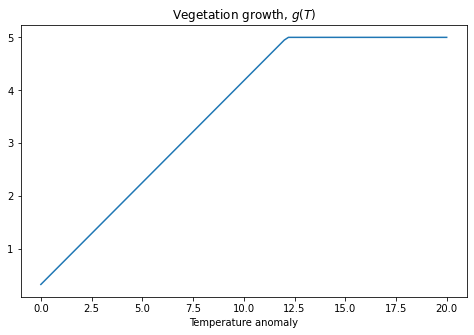

(0.33461538461538637, 5.0)

In [17]:
vege_growth = veggrowth(To + T_grid)


plt.plot(T_grid, vege_growth)
plt.xlabel("Temperature anomaly")
plt.title("Vegetation growth, $g(T)$")
plt.show()

vege_growth.min(), vege_growth.max()

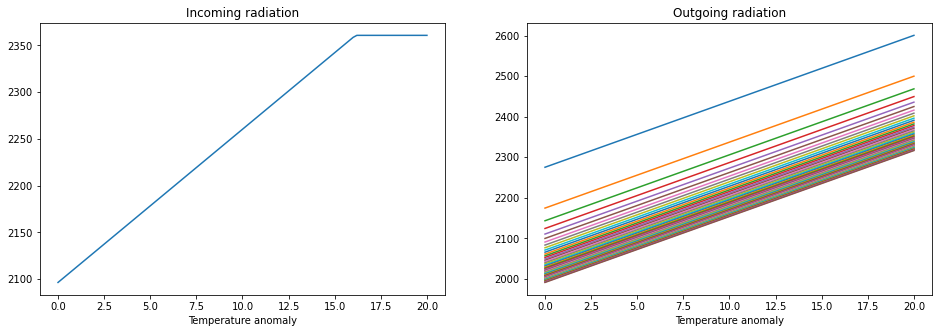

In [27]:
plt.subplots(1,2, figsize=(16, 5))
plt.subplot(121)

plt.title("Incoming radiation")
ri = Ri(To + T_grid)
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, ri)
plt.xlabel("Temperature anomaly")

plt.subplot(122)
plt.title("Outgoing radiation")
plt.plot(T_grid, ro)
plt.xlabel("Temperature anomaly")
plt.show()

Text(0.5, 0, 'Temperature anomaly')

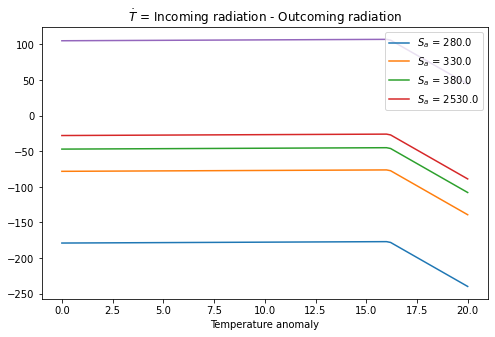

In [28]:
plt.title("$\\dot{T}$ = Incoming radiation - Outcoming radiation")
ri = Ri(To + T_mat[:, 0, :])
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, (ri - ro)[:, [0, 1,2,3, -1]])
plt.legend(["$S_a$ = {}".format(F) for F in F_grid[[0, 1, 2,-1]]])
plt.xlabel("Temperature anomaly")

In [29]:
T_grid[5], F_grid[17], C_grid[1]

(1.0, 1130.0, 260)

In [30]:
(ri - ro)[6, 17]

56.88065892593568

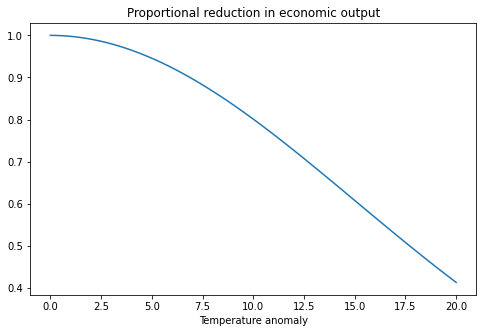

In [31]:
dG  = gamma_1 + gamma_2 * T_grid
G = gamma_1 * T_grid + gamma_2 / 2 * T_grid**2
plt.plot(T_grid, np.exp( -G) )
plt.xlabel("Temperature anomaly")
plt.title("Proportional reduction in economic output")
plt.show()

In [32]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 0. 
T_max  = 20. # 
hT     = 1.
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 250
C_max  = 500
hC     = 10
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 280. # 10. avaoid 
F_max = 2500. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 50.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(21, 26, 46)

In [75]:
# v0 =  - eta * T_mat - eta * F_mat
v0 =  eta * np.log(delta /4 * (9000/2.13 - F_mat)) + (eta - 1)  / delta * gamma_2 * T_mat / cearth * (B * np.log(C_mat/ C0) + kappa * (T_mat + To - Tkappa))

dG  = gamma_1 + gamma_2 * T_mat

epsilon  = 0.5
count    = 0
error    = 1.
tol      = 1e-8
max_iter = 1000
fraction = 0.1


while error > tol and count < max_iter:
    
    dvdT  = finiteDiff(v0, 0, 1, hT)
    dvdTT = finiteDiff(v0, 0, 2, hT)
    dvdC  = finiteDiff(v0, 1, 1, hC)
#     dvdC[dvdC >= - 1e-16] = - 1e-16
    dvdCC = finiteDiff(v0, 1, 2, hC)
    dvdF  = finiteDiff(v0, 2, 1, hF)
    dvdFF = finiteDiff(v0, 2, 2, hF)
        

    Ca = - eta / (dvdC + dvdF)
    Ca[Ca <= 1e-32] = 1e-32
    
    if count >=1:
        Ca = Ca * fraction + Ca_star * (1 - fraction)
    
    Ca = np.ones(T_mat.shape)
    A  = - delta * np.ones(T_mat.shape)
    B1 = Ri(T_mat + To) - Ro(T_mat + To, C_mat)
    B2 = Volcan
    B2 += Ca * sa
    B2 -= wa * C_mat * vegcover * veggrowth(T_mat +To)
    B2 += oceanatmphysflux(T_mat + To) * (1 - fracseaice(T_mat + To))
    B2 += oceanbioflux(T_mat + To, F_mat - Fo, sa) * (1 - fracseaice(T_mat + To))
    B2 += oceanatmcorrflux(C_mat) * (1 - fracseaice(T_mat + To))
    B3 = Ca
    C1 = 1e-4 * np.ones(T_mat.shape)
    C2 = 1e-4 * np.ones(T_mat.shape)
    C3 = np.zeros(T_mat.shape)
    D  = eta  * np.log(Ca) + (eta - 1) /delta * dG * B1

    out = PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, epsilon)
    v = out[2].reshape(v0.shape, order="F")

    rhs_error = A * v0 + B1 * dvdT + B2 * dvdC + B3 * dvdF + C1 * dvdTT + C2 * dvdCC + C3 * dvdFF + D
    rhs_error = np.max(abs(rhs_error))
    lhs_error = np.max(abs((v - v0)/epsilon))

    error = lhs_error
    v0 = v
    Ca_star = Ca
    count += 1

    print("Iteration %s: False Transient Error: %s; PDE Error %s" % (count, lhs_error, rhs_error))

print("Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

Iteration 1: False Transient Error: 2.9828962965439132e-05; PDE Error 10.613646772520156
Iteration 2: False Transient Error: 2.9702989877478103e-05; PDE Error 10.613646907780549
Iteration 3: False Transient Error: 2.9590178257876687e-05; PDE Error 10.613647059618643
Iteration 4: False Transient Error: 2.9471858027818598e-05; PDE Error 10.613647229573417
Iteration 5: False Transient Error: 2.934521930342271e-05; PDE Error 10.613647414618981
Iteration 6: False Transient Error: 2.9224163483831944e-05; PDE Error 10.613647607567714
Iteration 7: False Transient Error: 2.906576290229168e-05; PDE Error 10.613647805471032
Iteration 8: False Transient Error: 2.8897859351673105e-05; PDE Error 10.613647986885326
Iteration 9: False Transient Error: 2.8711352086929764e-05; PDE Error 10.613648159459103
Iteration 10: False Transient Error: 2.8540072008809148e-05; PDE Error 10.613648308688823
Iteration 11: False Transient Error: 2.8377802181012157e-05; PDE Error 10.613648453577241
Iteration 12: False T

Iteration 95: False Transient Error: 2.0403672948532403e-05; PDE Error 10.613659065398053
Iteration 96: False Transient Error: 2.0367973462498412e-05; PDE Error 10.613659128092479
Iteration 97: False Transient Error: 2.0306596383079523e-05; PDE Error 10.613659183349114
Iteration 98: False Transient Error: 2.018880807952428e-05; PDE Error 10.613659236730427
Iteration 99: False Transient Error: 2.000227851794989e-05; PDE Error 10.613659294114996
Iteration 100: False Transient Error: 1.9805625072422117e-05; PDE Error 10.61365935564936
Iteration 101: False Transient Error: 1.9639335533838675e-05; PDE Error 10.613659419568364
Iteration 102: False Transient Error: 1.9479000798128254e-05; PDE Error 10.613659480691297
Iteration 103: False Transient Error: 1.9331837535219165e-05; PDE Error 10.613659537523745
Iteration 104: False Transient Error: 1.919580137155208e-05; PDE Error 10.613659589726296
Iteration 105: False Transient Error: 1.906638702564578e-05; PDE Error 10.613659639648347
Iteration

Iteration 186: False Transient Error: 1.357111096922381e-05; PDE Error 10.613663526568075
Iteration 187: False Transient Error: 1.3345534227937605e-05; PDE Error 10.613663655351502
Iteration 188: False Transient Error: 1.3422937030327375e-05; PDE Error 10.613663701708333
Iteration 189: False Transient Error: 1.3352936321098241e-05; PDE Error 10.613663655254527
Iteration 190: False Transient Error: 1.3124973975209286e-05; PDE Error 10.613663537094396
Iteration 191: False Transient Error: 1.2958088717596183e-05; PDE Error 10.6136633820891
Iteration 192: False Transient Error: 1.2994334070981495e-05; PDE Error 10.6136632280149
Iteration 193: False Transient Error: 1.3023941249912241e-05; PDE Error 10.613663106298645
Iteration 194: False Transient Error: 1.3041217584941478e-05; PDE Error 10.613663041110954
Iteration 195: False Transient Error: 1.2984299555540701e-05; PDE Error 10.613663045795022
Iteration 196: False Transient Error: 1.3240282726201258e-05; PDE Error 10.613663123007768
Iter

Iteration 277: False Transient Error: 9.372108154437342e-06; PDE Error 10.613667627464338
Iteration 278: False Transient Error: 9.329393537704789e-06; PDE Error 10.613667467334267
Iteration 279: False Transient Error: 9.123530892551912e-06; PDE Error 10.613667315842008
Iteration 280: False Transient Error: 8.815513417470555e-06; PDE Error 10.613667189245575
Iteration 281: False Transient Error: 8.614514394711392e-06; PDE Error 10.613667102327895
Iteration 282: False Transient Error: 8.463110432899157e-06; PDE Error 10.61366710396942
Iteration 283: False Transient Error: 8.3577607270513e-06; PDE Error 10.613667160317277
Iteration 284: False Transient Error: 8.239174199786703e-06; PDE Error 10.613667269481425
Iteration 285: False Transient Error: 8.121956440731992e-06; PDE Error 10.61366742645663
Iteration 286: False Transient Error: 8.01597163047063e-06; PDE Error 10.613667631993565
Iteration 287: False Transient Error: 7.916136382846162e-06; PDE Error 10.613667879648744
Iteration 288: 

Iteration 371: False Transient Error: 4.867043443823604e-06; PDE Error 10.613671580297307
Iteration 372: False Transient Error: 4.726106197949775e-06; PDE Error 10.613671751097286
Iteration 373: False Transient Error: 4.629858153748501e-06; PDE Error 10.613672078707111
Iteration 374: False Transient Error: 4.580097623829715e-06; PDE Error 10.613672475812336
Iteration 375: False Transient Error: 4.535922059289987e-06; PDE Error 10.61367285791954
Iteration 376: False Transient Error: 4.49209926500771e-06; PDE Error 10.61367316239398
Iteration 377: False Transient Error: 4.468001208124406e-06; PDE Error 10.613673356304673
Iteration 378: False Transient Error: 4.4296863848103385e-06; PDE Error 10.613673453950412
Iteration 379: False Transient Error: 4.424502439093203e-06; PDE Error 10.613673466733417
Iteration 380: False Transient Error: 4.380732448794333e-06; PDE Error 10.613673423358023
Iteration 381: False Transient Error: 4.362905414723173e-06; PDE Error 10.613673367440413
Iteration 38

Iteration 465: False Transient Error: 3.4863502946791414e-06; PDE Error 10.613673562140434
Iteration 466: False Transient Error: 3.3785191249080526e-06; PDE Error 10.613673552616717
Iteration 467: False Transient Error: 3.395541909867461e-06; PDE Error 10.61367354555722
Iteration 468: False Transient Error: 3.432528160374204e-06; PDE Error 10.613673536405258
Iteration 469: False Transient Error: 3.4667486374928558e-06; PDE Error 10.61367352466516
Iteration 470: False Transient Error: 3.492159237339365e-06; PDE Error 10.613673511690195
Iteration 471: False Transient Error: 3.4850382064632868e-06; PDE Error 10.613673501518122
Iteration 472: False Transient Error: 3.4325908586652076e-06; PDE Error 10.61367349947733
Iteration 473: False Transient Error: 3.3267117771629273e-06; PDE Error 10.613673506465432
Iteration 474: False Transient Error: 3.2629837249942284e-06; PDE Error 10.613673523679893
Iteration 475: False Transient Error: 3.2257881059649662e-06; PDE Error 10.61367354835528
Iterat

Iteration 557: False Transient Error: 1.376633771599245e-05; PDE Error 10.613672598925007
Iteration 558: False Transient Error: 1.1446519394553434e-05; PDE Error 10.613672381136496
Iteration 559: False Transient Error: 1.0487319201502032e-05; PDE Error 10.613672538525691
Iteration 560: False Transient Error: 9.81445256797997e-06; PDE Error 10.613672983987897
Iteration 561: False Transient Error: 1.1327429319862858e-05; PDE Error 10.613673586342486
Iteration 562: False Transient Error: 1.6877301220574736e-05; PDE Error 10.613674203360574
Iteration 563: False Transient Error: 1.9105221099380287e-05; PDE Error 10.61367469743982
Iteration 564: False Transient Error: 1.5152855723954417e-05; PDE Error 10.613675019463983
Iteration 565: False Transient Error: 1.4474731756308756e-05; PDE Error 10.613675115271803
Iteration 566: False Transient Error: 1.5101537911732521e-05; PDE Error 10.613674985139369
Iteration 567: False Transient Error: 1.5919255247354158e-05; PDE Error 10.613674716950925
Ite

Iteration 648: False Transient Error: 2.3842698354314962e-05; PDE Error 10.613673536498482
Iteration 649: False Transient Error: 2.0602512719847255e-05; PDE Error 10.613673195147896
Iteration 650: False Transient Error: 1.9124603682030283e-05; PDE Error 10.61367280210385
Iteration 651: False Transient Error: 1.7729193530158227e-05; PDE Error 10.613672541191477
Iteration 652: False Transient Error: 1.6512899151166494e-05; PDE Error 10.613672550141303
Iteration 653: False Transient Error: 1.5465131184555503e-05; PDE Error 10.61367284531633
Iteration 654: False Transient Error: 2.743778486546944e-05; PDE Error 10.61367331496939
Iteration 655: False Transient Error: 1.9499970392189425e-05; PDE Error 10.613673912223533
Iteration 656: False Transient Error: 2.2350834456119628e-05; PDE Error 10.613674334465713
Iteration 657: False Transient Error: 2.263147675307664e-05; PDE Error 10.613674713865976
Iteration 658: False Transient Error: 2.3163581403196076e-05; PDE Error 10.613674869543559
Iter

Iteration 740: False Transient Error: 2.0138918898737757e-05; PDE Error 10.613673193920192
Iteration 741: False Transient Error: 2.6514873866290145e-05; PDE Error 10.613673572512596
Iteration 742: False Transient Error: 3.0240139381021436e-05; PDE Error 10.613674065177747
Iteration 743: False Transient Error: 3.004180013022051e-05; PDE Error 10.613674559053777
Iteration 744: False Transient Error: 2.5742527384409186e-05; PDE Error 10.613674958259026
Iteration 745: False Transient Error: 2.7486114191788147e-05; PDE Error 10.613675232095773
Iteration 746: False Transient Error: 2.921793637256087e-05; PDE Error 10.613675381288886
Iteration 747: False Transient Error: 3.1376774217051207e-05; PDE Error 10.6136754566229
Iteration 748: False Transient Error: 3.231864063479861e-05; PDE Error 10.613675432896969
Iteration 749: False Transient Error: 3.077663930639574e-05; PDE Error 10.613675333857316
Iteration 750: False Transient Error: 2.67348185047922e-05; PDE Error 10.613675255986095
Iterati

Iteration 832: False Transient Error: 1.8848940229077016e-05; PDE Error 10.613675358716762
Iteration 833: False Transient Error: 3.771936610519333e-05; PDE Error 10.613675421175913
Iteration 834: False Transient Error: 3.314113479291336e-05; PDE Error 10.613675477656216
Iteration 835: False Transient Error: 3.036314825521913e-05; PDE Error 10.613675483367103
Iteration 836: False Transient Error: 2.5960744096664712e-05; PDE Error 10.613675441511532
Iteration 837: False Transient Error: 3.0331247728554445e-05; PDE Error 10.61367534844726
Iteration 838: False Transient Error: 2.8730955563105454e-05; PDE Error 10.61367521508464
Iteration 839: False Transient Error: 3.0080253310416083e-05; PDE Error 10.613674968224302
Iteration 840: False Transient Error: 3.102890903505795e-05; PDE Error 10.61367479530054
Iteration 841: False Transient Error: 3.187000058346712e-05; PDE Error 10.613674514982506
Iteration 842: False Transient Error: 3.0059044334507234e-05; PDE Error 10.61367420161605
Iteratio

Iteration 923: False Transient Error: 2.2799354624680745e-05; PDE Error 10.613675161581227
Iteration 924: False Transient Error: 1.9694220739552293e-05; PDE Error 10.61367518792889
Iteration 925: False Transient Error: 1.8253072539664572e-05; PDE Error 10.613675256961983
Iteration 926: False Transient Error: 1.6594519379964368e-05; PDE Error 10.613675346401578
Iteration 927: False Transient Error: 1.9420923479174235e-05; PDE Error 10.613675429399677
Iteration 928: False Transient Error: 2.9624276635331626e-05; PDE Error 10.613675487415321
Iteration 929: False Transient Error: 2.6127904902750743e-05; PDE Error 10.613675496667668
Iteration 930: False Transient Error: 2.4617771885004913e-05; PDE Error 10.613675486402883
Iteration 931: False Transient Error: 2.236147457779225e-05; PDE Error 10.613675425512838
Iteration 932: False Transient Error: 2.727652190515073e-05; PDE Error 10.61367534597241
Iteration 933: False Transient Error: 2.556876376047512e-05; PDE Error 10.613675254252769
Iter

In [76]:
B1.max(), B1.min(), v0.min(), v0.mean(), v0.max(), Ca.min(), Ca.max(), v0.mean()

(31.72024865283447,
 -65.85381744291999,
 -146.60010036806597,
 6.719504813441656,
 86.43863639454563,
 1.0,
 1.0,
 6.719504813441656)

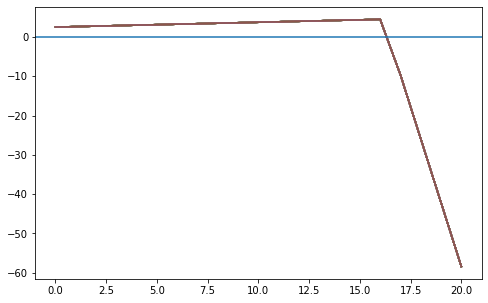

In [77]:
plt.plot(B1[:, 4, :])
plt.axhline(0)
plt.show()

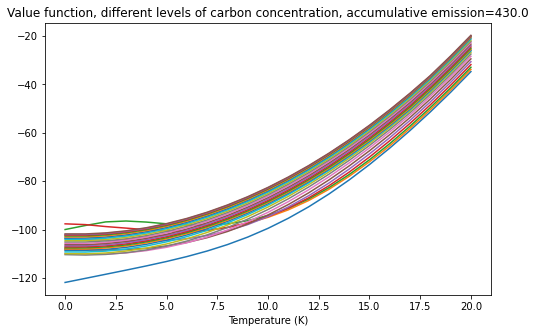

In [90]:
ii = 3
plt.plot(T_grid, v0[:, :, ii])
plt.xlabel("Temperature (K)")
plt.title("Value function, different levels of carbon concentration, accumulative emission={}".format(F_grid[ii]))
plt.show()

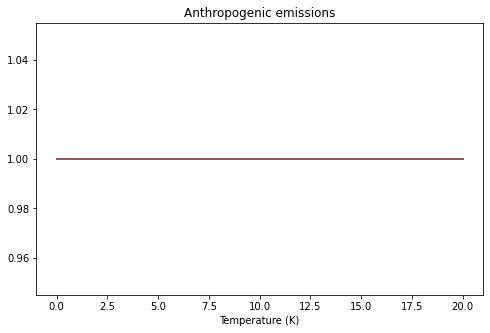

In [91]:
plt.plot(T_grid, Ca[:, :, ii])
plt.xlabel("Temperature (K)")
plt.title("Anthropogenic emissions")
plt.show()

/tmp/ipykernel_39751/579435035.py:3: UserWarning: No contour levels were found within the data range.
  ax.contour3D(T_mat[:, :, 10], C_mat[:, :, 10], Ca[:, :, ii], 90, cmap='binary')


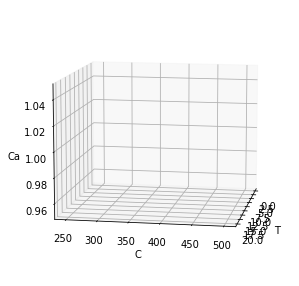

In [92]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(T_mat[:, :, 10], C_mat[:, :, 10], Ca[:, :, ii], 90, cmap='binary')
ax.set_xlabel('T')
ax.set_ylabel('C')
ax.set_zlabel('Ca')
ax.view_init(10, 10)

In [93]:
t_max = 100.
dt = 1/12
gridpoints = (T_grid, C_grid, F_grid)   
Ca_func = RegularGridInterpolator(gridpoints, Ca)

T_0 = To + 1.1
C_0 = 275.77
F_0 = 408.45

def get_e(x):
    return Ca_func([x[0] - To, x[1], x[2]])

# Ocean albedo
def alphaocean_1d(T):
    if T < Talphaocean_low:
        return alphaocean_max
    elif T < Talphaocean_high:
        return alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return alphaocean_min

# Vegetation growth function
def veggrowth_1d(T):
    if T < Tlow:
        return 0
    if (T >= Tlow) and (T < Topt1):
        return acc / (Topt1 - Tlow) * (T - Tlow)
    if (T >= Topt1) and (T <= Topt2):
        return acc
    if (T > Topt2) and (T < Thigh):
        #return acc
        return acc / (Topt2 - Thigh) * (T - Thigh)
    if T > Thigh:
        #return acc
        return 0

def oceanatmphysflux_1d(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def fracseaice_1d(T):
    if T < Talphaocean_low:
        return 1
    elif T < Talphaocean_high:
        return 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return 0

def biopump_1d(Cc):
    if Cc < Cbio_low:
        return 1
    elif Cc < Cbio_high:
        return 1 - 1 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
    else: 
        return 0


def oceanbioflux_1d(T, F, sa):
     return 1/tauc * (coc0 * (np.exp(bB * biopump_1d(F) * (T - T0))))

def oceanatmcorrflux_1d(C):
    return 1 / tauc * (- cod * C)


def mu_T(x):
    Ri_t = 1 / cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(x[0])))
    Ro_t = 1 / cearth * (kappa * (x[0] - Tkappa) -  B * np.log(x[1] / C0))
    return Ri_t - Ro_t

def mu_C(x):
    Ca_t = Ca_func([x[0] - To, x[1], x[2]])
    dC = Volcan
    dC += Ca_t * sa
    dC -= wa * x[1] * vegcover * veggrowth_1d(x[0])
    dC += oceanatmphysflux_1d(x[0]) * (1 - fracseaice_1d(x[0]))
    dC += oceanbioflux_1d(x[0], x[2], sa) * (1 - fracseaice_1d(x[0]))
    dC += oceanatmcorrflux_1d(x[1]) * (1 - fracseaice_1d(x[0]))
    return dC

def mu_Sa(x):
    return Ca_func([x[0] - To, x[1], x[2]])

years  = np.arange(0, t_max + dt, dt)
pers   = len(years)

hist      = np.zeros([pers, 3])
e_hist    = np.zeros([pers])


for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [T_0, C_0, F_0] # logL
        e_hist[0] = get_e(hist[0, :])

    else:
        # other periods
        e_hist[tm] = get_e(hist[tm-1,:])

        hist[tm,0] = hist[tm-1,0] + mu_T(hist[tm-1,:]) * dt
        hist[tm,1] = hist[tm-1,1] + mu_C(hist[tm-1,:]) * dt
        hist[tm,2] = hist[tm-1,2] + mu_Sa(hist[tm-1,:]) * dt


Text(0.5, 1.0, '$S_a$')

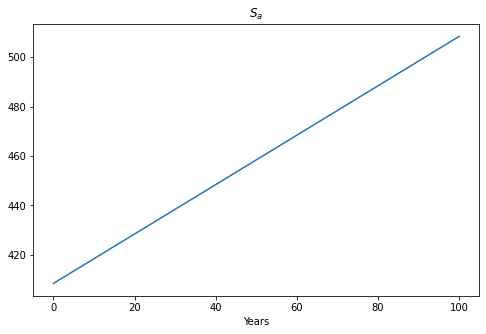

In [95]:
plt.plot(years, hist[:, 2])
plt.xlabel("Years")
plt.title("$S_a$")

Text(0.5, 1.0, 'Emission')

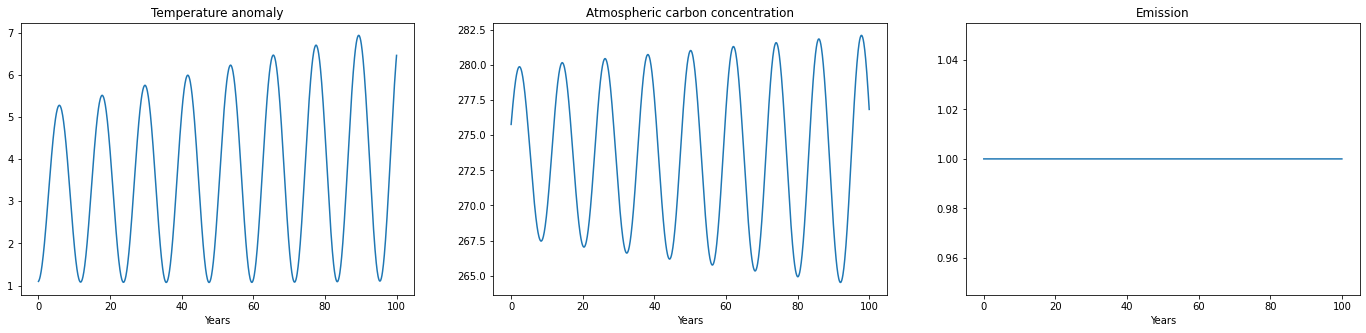

In [96]:
plt.subplots(1,3, figsize=(24,5))
plt.subplot(131)
plt.plot(years, hist[:, 0] - To)
plt.xlabel("Years")
plt.title("Temperature anomaly")
plt.subplot(132)
plt.plot(years, hist[:, 1])
plt.xlabel("Years")
plt.title("Atmospheric carbon concentration")
plt.subplot(133)
plt.plot(years, e_hist)
plt.xlabel("Years")
plt.title("Emission")